In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

2023-10-10 11:34:39.926154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 11:34:40.952551: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Data

In [2]:
# hardcoded stuff
df_path = "data/otu_table_example.csv"

The original dataset has taxa counts as rows and samples as columns. Since the goal here is to predict taxa counts in the same sample I transpose the original data such that one row represents taxa counts from the same sample. 

In [3]:
df = pd.read_csv(df_path, index_col="Unnamed: 0").T

In [4]:
print(df)

              1050608  130468   3589405  355102   1081058  189592   354275   \
E000823.1.8         0        0        0        0        0        0        0   
E000823.2.6         0        0        0        0        0        0        0   
E000823.4.0         0        0        0        0        0        0        0   
E000823.5.0         0        0        0        0        0        0        0   
E000823.5.7         0        0        0        0        0        0        0   
...               ...      ...      ...      ...      ...      ...      ...   
E014086.30.4        0        0        0        0        0        1       11   
E014086.32.4        0        0        0        0        0        0       13   
E014086.33.5        0        0        0        0        0        0        0   
E014086.34.4        0        0        0        0        0        1        0   
E014086.36.0        0        0        0        0        0        0        0   

              4327628  326749   183857   ...  31792

The dataset contains 521 samples of 7244 taxa, most of which are very sparsely populated 

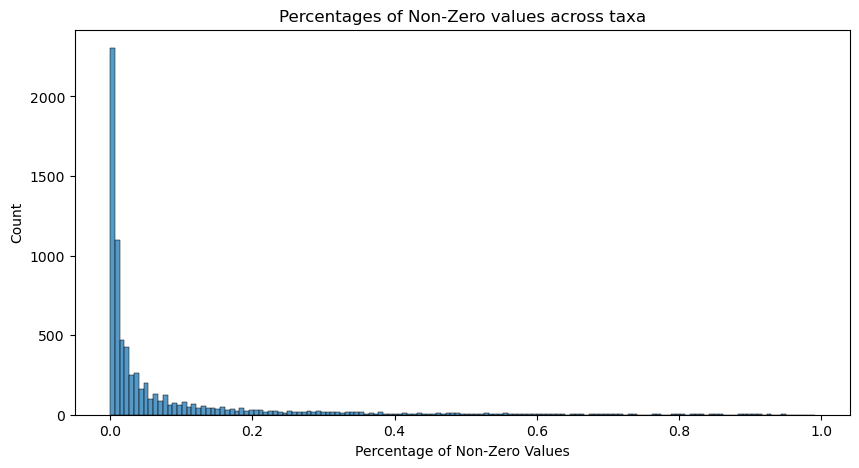

In [5]:
non_zero_value_counts = pd.Series([len(df[col][df[col] != 0]) for col in df.columns])
non_zero_value_pcts = non_zero_value_counts / len(df)

plt.figure(figsize=(10,5))
sns.histplot(non_zero_value_pcts)
plt.title("Percentages of Non-Zero values across taxa")
plt.xlabel("Percentage of Non-Zero Values")
plt.show()

In [6]:
non_zero_value_counts.describe()

count   7244.000000
mean      38.409856
std       71.884313
min        0.000000
25%        3.000000
50%        9.000000
75%       37.000000
max      516.000000
dtype: float64

### Preprocessing

Here is how an example taxa with id 302746 looks like before preprocessing

In [7]:
zero_values_percentage_cutoff = 0.5 # at least 50% of taxa must be non-zero values
smoothing_window_size = 5
df = preprocess(zero_values_percentage_cutoff=zero_values_percentage_cutoff, smoothing_window_size=smoothing_window_size)

2023-10-10 11:34:47.709581: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 11:34:47.873875: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 11:34:47.899253: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 11:34:47.903880: I tensorflow/core/platform/cpu_featu

In [8]:
example_taxa_idx = 302746
example_taxa_sequence_raw = df[example_taxa_idx]

In [9]:
example_taxa_sequence_preprocessed = df[example_taxa_idx]
df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
E000823.1.8,0.000000,0.000221,0.195402,0.002871,0.000000,0.252560,0.009901,0.145455,0.000000,0.087963,...,0.000000,0.237179,0.000433,0.102041,0.000000,0.042448,0.507874,0.063005,0.010525,0.043189
E000823.2.6,0.052888,0.000273,0.137931,0.012440,0.000000,0.204778,0.007921,0.109091,0.000000,0.120370,...,0.000000,0.173077,0.000939,0.163265,0.000067,0.037373,0.437008,0.056729,0.010298,0.019934
E000823.4.0,0.052888,0.000256,0.160920,0.013397,0.000000,0.443686,0.019802,0.072727,0.000000,0.074074,...,0.000000,0.179487,0.000987,0.183673,0.000067,0.053983,0.389764,0.069040,0.032819,0.013289
E000823.5.0,0.052888,0.000204,0.103448,0.053589,0.000000,0.375427,0.019802,0.054545,0.000000,0.064815,...,0.000000,0.166667,0.003901,0.183673,0.000089,0.048139,0.338583,0.052505,0.030623,0.000000
E000823.5.7,0.052888,0.000204,0.195402,0.053589,0.046985,0.382253,0.021782,0.054545,0.112668,0.078704,...,0.000000,0.147436,0.080911,0.122449,0.053025,0.044909,0.287402,0.054919,0.083269,0.013289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.22.5,0.054103,0.115345,0.172414,0.001435,0.058205,0.044369,0.033663,0.418182,0.361913,0.402778,...,0.339315,0.115385,0.000024,0.428571,0.045208,0.085205,0.177165,0.131201,0.328075,0.289037
E014086.23.4,0.084802,0.145123,0.183908,0.006699,0.062412,0.088737,0.035644,0.545455,0.462215,0.532407,...,0.428222,0.115385,0.000747,0.489796,0.061491,0.110889,0.212598,0.174412,0.407474,0.209302
E014086.24.5,0.094833,0.161664,0.379310,0.009091,0.105189,0.143345,0.067327,0.563636,0.874141,0.800926,...,0.644372,0.205128,0.000747,0.489796,0.084206,0.133959,0.283465,0.297284,0.596487,0.325581
E014086.26.4,0.059574,0.153453,0.597701,0.009091,0.183029,0.334471,0.071287,0.709091,0.932949,0.828704,...,0.712072,0.243590,0.000747,0.408163,0.071408,0.196555,0.334646,0.417139,0.741297,0.365449


#### Here is what our example taxa sequence 302746 looks like after preprocessing

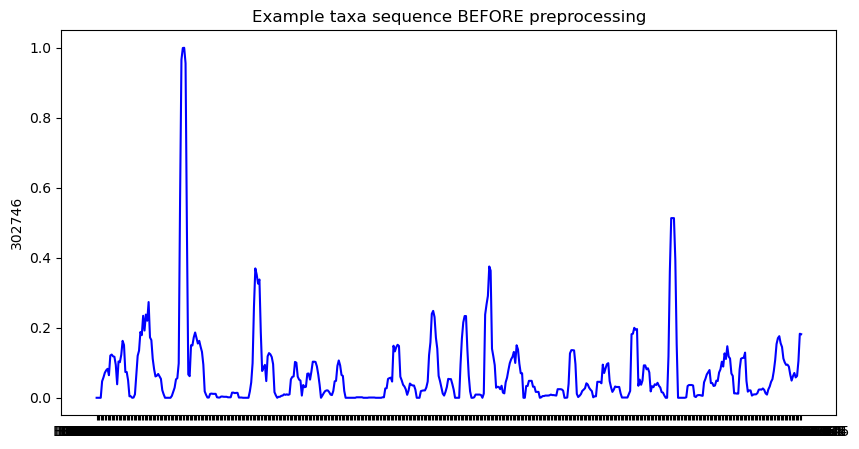

In [10]:
plot_a_taxa_sequence(sequence=example_taxa_sequence_raw, color="blue", title="Example taxa sequence BEFORE preprocessing")

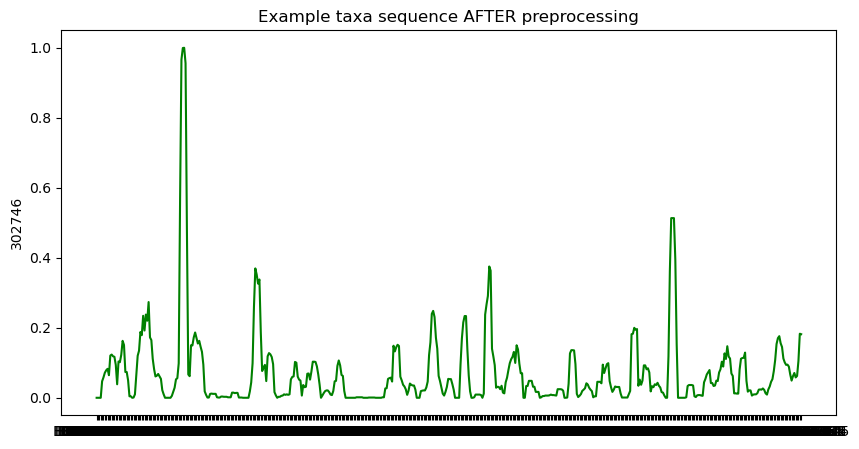

In [11]:
plot_a_taxa_sequence(sequence=example_taxa_sequence_preprocessed, color="green", title="Example taxa sequence AFTER preprocessing")

### Features and Targets

Now I prepare feature sequences and target sequences. For a detailed description of how this happens please read the description to function cut_to_sequences(). You will find it in functions.py

In [12]:
seq_length = 50
cutoff = 411

X_sequences, y_targets = cut_to_sequences(feats_df=df, seq_length=seq_length)

X_sequences_train = X_sequences[:cutoff]
y_targets_train = y_targets[:cutoff]

X_sequences_test = X_sequences[cutoff:]
y_targets_test = y_targets[cutoff:]

print(f"Length of data: {len(df)}")
print(f"Total sequences: {len(X_sequences)}")
print(f"Train sequences: {len(X_sequences_train)}")
print(f"Test sequences: {len(X_sequences_test)}")

Length of data: 516
Total sequences: 466
Train sequences: 411
Test sequences: 55


### The Model

In [13]:
reg = 1e-12
loss=mae_ignore_zeros(false_positives_penalty_factor=0.1)

n_feats = len(df.columns)

model = Sequential()
model.add(keras.Input(shape=(seq_length, n_feats)))
model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
model.add(keras.layers.Dense(2048, activation="tanh", kernel_regularizer=l1_l2(reg)))
model.add(keras.layers.Dense(n_feats, activation="relu", kernel_regularizer=l1_l2(reg)))

model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])

model.summary()

2023-10-10 11:34:57.570228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-10 11:34:57.595963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-10 11:34:57.596338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024)              5025792   
                                                                 
 dense (Dense)               (None, 2048)              2099200   
                                                                 
 dense_1 (Dense)             (None, 202)               413898    
                                                                 
Total params: 7538890 (28.76 MB)
Trainable params: 7538890 (28.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training and Validation

In [14]:
model.fit(x=X_sequences_train, y=y_targets_train, validation_split=0.05, epochs=10)

Epoch 1/10


2023-10-10 11:35:00.520561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-10 11:35:00.576213: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb02c3bd2b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 11:35:00.576243: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-10-10 11:35:00.581962: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 11:35:00.595491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-10 11:35:00.703255: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

13/13 [==============================] - 3s 67ms/step - loss: 27.0925 - mae: 0.1101 - mape: 4190432.5000 - val_loss: 21.4636 - val_mae: 0.0893 - val_mape: 560135.0625
Epoch 2/10
13/13 [==============================] - 1s 47ms/step - loss: 19.7426 - mae: 0.0847 - mape: 2013351.8750 - val_loss: 17.6729 - val_mae: 0.0869 - val_mape: 813152.0000
Epoch 3/10
13/13 [==============================] - 1s 46ms/step - loss: 15.5297 - mae: 0.0733 - mape: 1262299.7500 - val_loss: 15.2943 - val_mae: 0.0859 - val_mape: 549629.0000
Epoch 4/10
13/13 [==============================] - 1s 45ms/step - loss: 13.0136 - mae: 0.0668 - mape: 848714.5625 - val_loss: 13.8016 - val_mae: 0.0851 - val_mape: 448142.0625
Epoch 5/10
13/13 [==============================] - 1s 52ms/step - loss: 11.4920 - mae: 0.0633 - mape: 851942.7500 - val_loss: 12.5611 - val_mae: 0.0809 - val_mape: 694795.3125
Epoch 6/10
13/13 [==============================] - 1s 57ms/step - loss: 10.3200 - mae: 0.0596 - mape: 771603.1875 - val_lo

In [15]:
y_pred = model.predict(X_sequences_test)

2/2 [==============================] - 0s 8ms/step


In [16]:
y_test_df = pd.DataFrame(y_targets_test)
y_pred_df = pd.DataFrame(y_pred)

In [17]:
y_test_df

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,0.037386,0.013270,0.436782,0.017225,0.147265,0.109215,0.615842,0.254545,0.009343,0.046296,...,0.268352,0.153846,0.021143,0.163265,0.053025,0.587819,0.082677,0.266264,0.265606,0.302326
1,0.019149,0.012742,0.344828,0.014833,0.117812,0.054608,0.483168,0.254545,0.009343,0.046296,...,0.238989,0.083333,0.021143,0.163265,0.040316,0.453091,0.062992,0.202535,0.222715,0.235880
2,0.012158,0.014207,0.264368,0.014354,0.112202,0.058020,0.843564,0.254545,0.018137,0.101852,...,0.196574,0.070513,0.020396,0.142857,0.076992,0.786066,0.055118,0.393724,0.255036,0.481728
3,0.008207,0.010511,0.103448,0.008134,0.069425,0.040956,0.506931,0.072727,0.096455,0.074074,...,0.079119,0.032051,0.018687,0.061224,0.062362,0.582744,0.055118,0.300905,0.142139,0.385382
4,0.008207,0.004054,0.057471,0.006699,0.062412,0.037543,0.435644,0.018182,0.089860,0.078704,...,0.061990,0.032051,0.050690,0.040816,0.058386,0.470624,0.059055,0.257333,0.089946,0.338870
5,0.001520,0.004940,0.137931,0.003349,0.012623,0.098976,0.475248,0.000000,0.089035,0.078704,...,0.013051,0.121795,0.128928,0.040816,0.056085,0.616887,0.192913,0.305854,0.089652,0.335548
6,0.001520,0.007478,0.137931,0.006220,0.012623,0.109215,0.487129,0.000000,0.092883,0.078704,...,0.013051,0.134615,0.147687,0.040816,0.056085,0.653491,0.212598,0.324321,0.100833,0.335548
7,0.000608,0.006712,0.091954,0.008612,0.011921,0.112628,0.077228,0.000000,0.244573,0.013889,...,0.004894,0.179487,0.172972,0.020408,0.004221,0.257767,0.204724,0.107423,0.037753,0.049834
8,0.000000,0.006184,0.114943,0.008134,0.011921,0.129693,0.073267,0.000000,0.165155,0.004630,...,0.000816,0.185897,0.173140,0.000000,0.000424,0.246386,0.200787,0.107906,0.070708,0.003322
9,0.000000,0.006490,0.229885,0.016268,0.080645,0.133106,0.089109,0.000000,0.169827,0.000000,...,0.267537,0.160256,0.132155,0.000000,0.009225,0.261150,0.200787,0.126735,0.127246,0.000000


In [18]:
y_pred_df

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,0.045905,0.000000,0.197821,0.000000,0.060268,0.161121,0.259140,0.238176,0.116724,0.251200,...,0.311619,0.101185,0.000000,0.218503,0.000000,0.313171,0.106310,0.215579,0.244259,0.214974
1,0.047681,0.000000,0.201033,0.000000,0.068685,0.139487,0.261720,0.245363,0.099485,0.260042,...,0.331612,0.092181,0.000000,0.225065,0.000000,0.314496,0.097899,0.220699,0.256353,0.222013
2,0.046826,0.000000,0.179402,0.000000,0.059839,0.108467,0.228523,0.224478,0.075786,0.236045,...,0.304550,0.071940,0.000000,0.208114,0.000000,0.276084,0.079163,0.197064,0.232264,0.206468
3,0.045783,0.000000,0.190065,0.000000,0.060568,0.097075,0.273090,0.223485,0.078228,0.254368,...,0.328260,0.075317,0.000000,0.213187,0.000000,0.323572,0.070643,0.227045,0.265399,0.214501
4,0.037663,0.000000,0.155820,0.000000,0.024916,0.081763,0.223991,0.176105,0.062796,0.202395,...,0.256864,0.063805,0.000000,0.175731,0.000000,0.268339,0.063268,0.185518,0.209401,0.181899
5,0.034744,0.000000,0.130424,0.000000,0.017324,0.067624,0.183752,0.150992,0.052222,0.174547,...,0.225369,0.051651,0.000000,0.160143,0.000000,0.222745,0.053008,0.155855,0.165952,0.164993
6,0.040274,0.000000,0.123575,0.000000,0.000000,0.073499,0.154176,0.136731,0.056587,0.157294,...,0.184339,0.066872,0.000000,0.163592,0.000000,0.194019,0.074402,0.133110,0.127795,0.137097
7,0.046803,0.000000,0.126199,0.000000,0.000000,0.080466,0.140358,0.132514,0.059100,0.153250,...,0.166043,0.089294,0.000000,0.175518,0.000000,0.183071,0.102389,0.122212,0.098006,0.113728
8,0.044624,0.000000,0.123704,0.003468,0.000000,0.093312,0.083601,0.102731,0.036764,0.114413,...,0.103121,0.115645,0.000000,0.158404,0.000000,0.124785,0.148625,0.088443,0.046032,0.078059
9,0.046286,0.000000,0.127952,0.015656,0.000000,0.102447,0.050296,0.082616,0.022384,0.090335,...,0.072046,0.137209,0.000000,0.146571,0.000000,0.092228,0.181696,0.071494,0.016735,0.051921


Usually at least some of the taxa are not predictable by a model. Then it returns zeros for their entire sequence

In [19]:
non_predicted_cols = [col for col in y_pred_df.columns if all(y_pred_df[col] == 0.0)]
n_non_predicted_cols = len(non_predicted_cols)

print(f"Total taxa not predicted: {n_non_predicted_cols}, {(n_non_predicted_cols/len(y_test_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 20, 9.900990099009901% of all taxa


The next section allows to examine individual true and predicted sequences

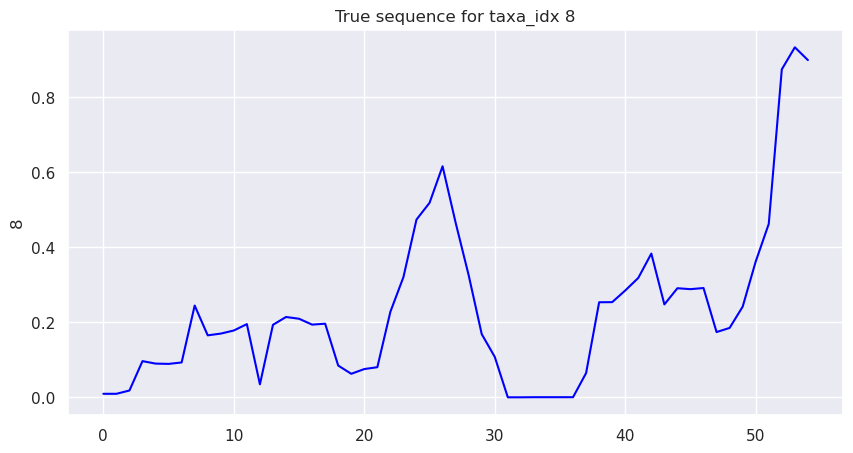

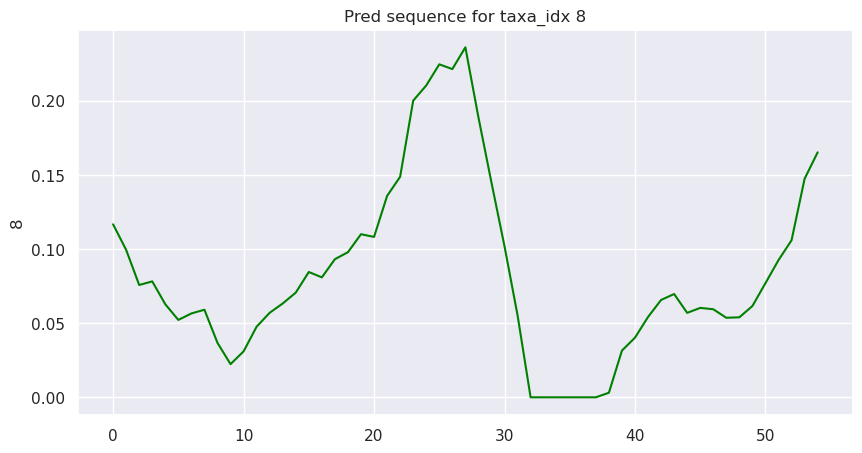

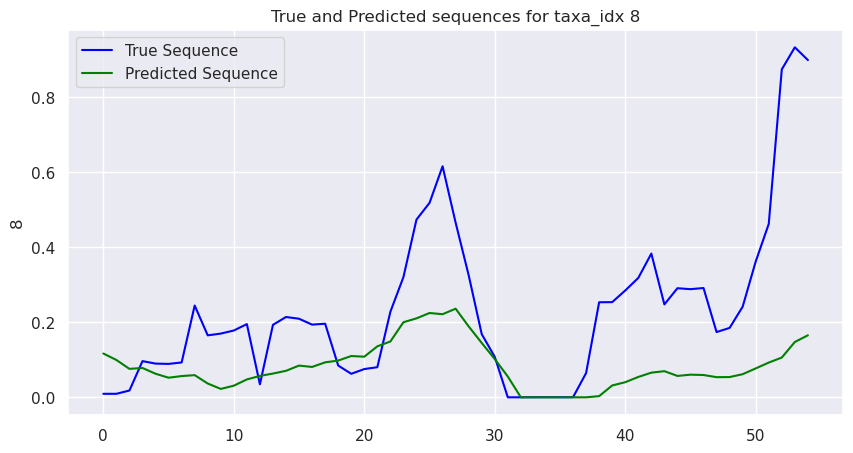

In [20]:
target_taxa = 8
true_sequence = y_test_df[target_taxa]
pred_sequence = y_pred_df[target_taxa]

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

Now I look at the performance across different sequences

In [21]:
errors_df = calculate_percentage_errors(y_pred_df, y_test_df)
errors_df.describe()


,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,17076575.477498,2249847427.535937,0.561673,80208785.608624,466403157.329694,0.583754,360036.847431,0.574530,11941345.901067,0.488291,...,0.691462,0.477951,274139274.854835,0.447684,391535912.624306,0.709272,0.822074,0.827047,49383.317085,0.744896
std,88869780.894292,2965623042.675204,0.460963,87583691.743232,520886900.586008,0.337418,2670098.313002,0.496040,87052727.001151,0.334225,...,0.626240,0.380724,439896284.312762,0.336789,411348554.614606,0.590052,1.154217,0.543912,216441.684731,0.554714
min,0.056381,40543762.873899,0.009021,0.039105,0.114595,0.000516,0.000000,0.001172,0.000000,0.004353,...,0.082618,0.001052,0.451208,0.030689,0.140323,0.000000,0.021602,0.061414,0.034317,0.013803
25%,0.945442,160386356.074687,0.175432,9569377.862666,5.633336,0.329104,0.322963,0.215576,0.713373,0.200092,...,0.225229,0.127242,10113901.663795,0.165007,6254048.296031,0.302614,0.230244,0.368099,0.227772,0.361173
50%,0.987448,1148512812.167328,0.519154,62200956.107327,238429169.327148,0.540835,0.667985,0.482371,2.051022,0.437498,...,0.503373,0.442331,35880270.188224,0.404426,238323911.852320,0.459068,0.472467,0.916332,0.536045,0.614896
75%,1.379576,2916510471.775547,0.778975,129186601.145987,848527337.899556,0.853621,1.393421,0.884294,4.591352,0.706494,...,0.941738,0.762929,402750012.683250,0.714024,638583002.798297,0.997326,0.905163,1.164300,1.057814,0.986045
max,556230995.613033,9999999866.485682,2.219219,368421047.712630,1830294505.717225,1.428367,19801979.933635,2.827453,645781799.566951,1.281966,...,2.808277,1.358682,1731403641.968648,1.365822,1445355232.986282,2.368186,5.920823,2.479546,1131682.570559,2.565714


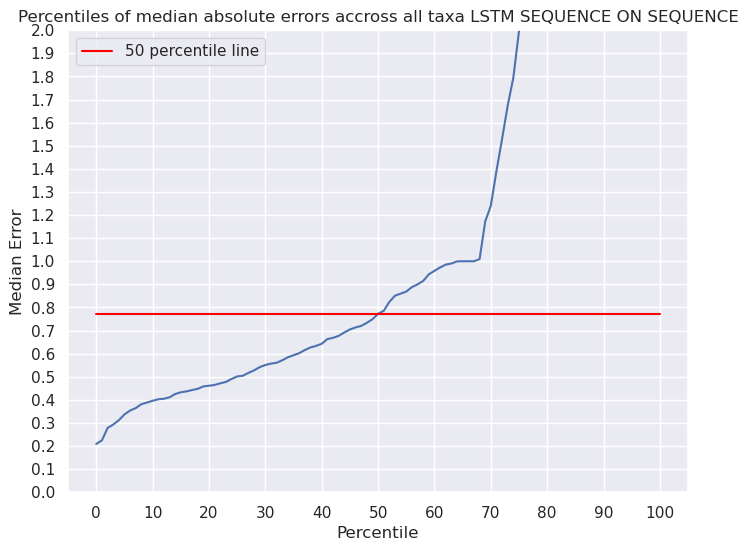

In [22]:
percentile_graph(errors_df, "accross all taxa LSTM SEQUENCE ON SEQUENCE", y_top_lim=2)

Same graph, but only for those taxa that are not all predicted zero

In [23]:
only_predicted_errors = errors_df[errors_df.columns[~(errors_df.columns.isin(non_predicted_cols))]]
only_predicted_errors.describe()

,0,2,3,4,5,6,7,8,9,10,...,192,193,194,195,196,197,198,199,200,201
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,17076575.477498,0.561673,80208785.608624,466403157.329694,0.583754,360036.847431,0.574530,11941345.901067,0.488291,4381161.972924,...,0.691462,0.477951,274139274.854835,0.447684,391535912.624306,0.709272,0.822074,0.827047,49383.317085,0.744896
std,88869780.894292,0.460963,87583691.743232,520886900.586008,0.337418,2670098.313002,0.496040,87052727.001151,0.334225,22761276.050359,...,0.626240,0.380724,439896284.312762,0.336789,411348554.614606,0.590052,1.154217,0.543912,216441.684731,0.554714
min,0.056381,0.009021,0.039105,0.114595,0.000516,0.000000,0.001172,0.000000,0.004353,0.000000,...,0.082618,0.001052,0.451208,0.030689,0.140323,0.000000,0.021602,0.061414,0.034317,0.013803
25%,0.945442,0.175432,9569377.862666,5.633336,0.329104,0.322963,0.215576,0.713373,0.200092,0.361566,...,0.225229,0.127242,10113901.663795,0.165007,6254048.296031,0.302614,0.230244,0.368099,0.227772,0.361173
50%,0.987448,0.519154,62200956.107327,238429169.327148,0.540835,0.667985,0.482371,2.051022,0.437498,0.827857,...,0.503373,0.442331,35880270.188224,0.404426,238323911.852320,0.459068,0.472467,0.916332,0.536045,0.614896
75%,1.379576,0.778975,129186601.145987,848527337.899556,0.853621,1.393421,0.884294,4.591352,0.706494,1.742223,...,0.941738,0.762929,402750012.683250,0.714024,638583002.798297,0.997326,0.905163,1.164300,1.057814,0.986045
max,556230995.613033,2.219219,368421047.712630,1830294505.717225,1.428367,19801979.933635,2.827453,645781799.566951,1.281966,120481926.102237,...,2.808277,1.358682,1731403641.968648,1.365822,1445355232.986282,2.368186,5.920823,2.479546,1131682.570559,2.565714


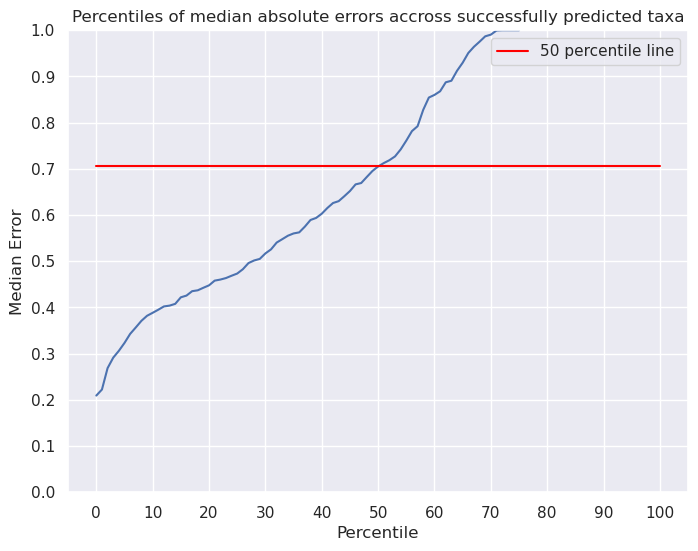

In [24]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa", y_top_lim=1)